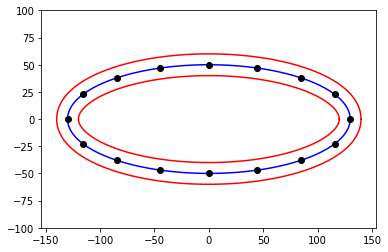

In [10]:
%matplotlib inline

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
import scipy.special
import scipy.interpolate
import scipy.optimize
import scipy.integrate

# Parameters:

# ellipse major axis "radius"
ellipse_a = 260/2.0

# ellipse minor axis "radius"
ellipse_b = 100/2.0

# whether to space out equally in arclength (0) - or equal-t (1)
blend_fraction = 0.6

# number of holes
N_holes = 16

# outer offset (outwards from ellipse)
outer_offset = 10

# inner offset (inwards from ellipse) (or zero if the ellipse line is to be on the inside)
inner_offset = 10

hole_radius=3

title="window-{}-{}-{}-{}-{}".format(int(ellipse_a*2), int(ellipse_b*2), N_holes, outer_offset, inner_offset)





ellipse_eccentricity = 1 - (ellipse_a)**2 / (ellipse_b)**2

t = np.linspace(0,2*math.pi, 10000)

ellipse_points = np.array( [
    ellipse_a*np.cos(t),
    ellipse_b*np.sin(t)
] ).T


# ellipse tangents:
ellipse_tangents = np.array( [
    -ellipse_a*np.sin(t),
    ellipse_b*np.cos(t)
] ).T
#ellipse_tangents /=  np.linalg.norm(ellipse_tangents, axis=1).reshape(-1,1)

ellipse_normals = np.array( [
    ellipse_b*np.cos(t),
    ellipse_a*np.sin(t)
] ).T
ellipse_normals /=  np.linalg.norm(ellipse_normals, axis=1).reshape(-1,1)

#ellipse_arcdeltas = np.sqrt( ellipse_a**2.0*np.sin(t)**2.0 + ellipse_b**2.0*np.cos(t)**2.0 )
#print(ellipse_arcdeltas - np.linalg.norm(ellipse_tangents, axis=1) ) # ok

outer_offset_ellipse_points = ellipse_points + outer_offset*ellipse_normals

inner_offset_ellipse_points = ellipse_points - inner_offset*ellipse_normals

# ellipse arclengths:
# http://www.wolframalpha.com/input/?i=integral+sqrt(a%5E2+*+sin(t)%5E2+%2B+b%5E2*cos(t)%5E2+)
ellipse_arclengths = (
    np.sqrt( (ellipse_b**2.0 - ellipse_a**2.0) * np.cos(2.0* t) + ellipse_a**2.0 + ellipse_b**2.0 ) 
    * scipy.special.ellipeinc(t, ellipse_eccentricity) / np.sqrt( (
        (ellipse_b**2.0 - ellipse_a**2.0) * np.cos(2.0* t) + ellipse_a**2.0 + ellipse_b**2.0
    ) / ellipse_b**2.0 ) 
)


# Find drill holes
end_arclength = ellipse_arclengths[-1]
end_angle = 2.0*math.pi

t_holes_equal_arclength = []
for n_hole in range(N_holes):
    # equi-arclength
    hole_arclength = end_arclength*n_hole / N_holes
    f_ellipse_arclengths_delta = scipy.interpolate.interp1d(t, ellipse_arclengths - hole_arclength, kind='cubic')
    t_hole = scipy.optimize.brentq(f_ellipse_arclengths_delta, 0, 2*math.pi)
    t_holes_equal_arclength.append(t_hole)
t_holes_equal_arclength = np.array(t_holes_equal_arclength)

# equi-t - angle on original circle of ellipse before it was squashed
t_holes_equal_t = np.linspace(0, math.pi*2.0, N_holes+1)[0:-1]


# blend t_holes values for the two ways - looks quite neatly spaced
w = blend_fraction
t_holes = (t_holes_equal_t*w + t_holes_equal_arclength*(1-w))


hole_points = np.array( [
    ellipse_a*np.cos(t_holes),
    ellipse_b*np.sin(t_holes)
] ).T

hole_pts_ellipse_normals = np.array( [
    ellipse_b*np.cos(t_holes),
    ellipse_a*np.sin(t_holes)
] ).T
hole_pts_ellipse_normals /=  np.linalg.norm(hole_pts_ellipse_normals, axis=1).reshape(-1,1)

hole_points += hole_pts_ellipse_normals * (outer_offset - inner_offset)/2.0

    
fig, ax = plt.subplots()
ax.plot( ellipse_points[:,0], ellipse_points[:,1], 'b-')

ax.plot( outer_offset_ellipse_points[:,0], outer_offset_ellipse_points[:,1], 'r-')

ax.plot( inner_offset_ellipse_points[:,0], inner_offset_ellipse_points[:,1], 'r-')

ax.plot( hole_points[:,0], hole_points[:,1], 'ko')
ax.axis('Equal')
plt.show()


from dxfwrite import DXFEngine as dxf
drawing = dxf.drawing( title+'.dxf' )

polyline= dxf.polyline()
vertices = [ (p[0], p[1]) for p in outer_offset_ellipse_points ]
polyline.add_vertices( vertices )
drawing.add(polyline)

polyline= dxf.polyline()
vertices = [ (p[0], p[1]) for p in inner_offset_ellipse_points ]
polyline.add_vertices( vertices )
drawing.add(polyline)

for hole_pt in hole_points:
    circle = dxf.circle( hole_radius, (hole_pt[0], hole_pt[1]))
    drawing.add(circle)

drawing.save()